# Emulsion Steady Shear (Herschel-Bulkley)

Fit multiple emulsion volume fractions with Herschel–Bulkley to mirror pyRheo rotation demos.

**Data:** examples/data/pyRheo/emulsion/*.csv


In [1]:
# Google Colab compatibility - uncomment if running in Colab
# !pip install -q rheojax
# from google.colab import drive
# drive.mount('/content/drive')


## Setup and Imports

In [2]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
%matplotlib inline

import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from rheojax.core.data import RheoData
from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.fractional_maxwell_model import FractionalMaxwellModel
from rheojax.models.generalized_maxwell import GeneralizedMaxwell
from rheojax.models.herschel_bulkley import HerschelBulkley
from rheojax.pipeline.base import Pipeline
from rheojax.transforms.mastercurve import Mastercurve

jax, jnp = safe_import_jax()
verify_float64()
np.set_printoptions(precision=4, suppress=True)
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
warnings.filterwarnings('ignore', category=RuntimeWarning)

def r2_complex(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
    ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
    return float(1 - ss_res / ss_tot)

def mpe(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float(np.mean(np.abs(y_true - y_pred) / np.maximum(np.abs(y_true), 1e-12)) * 100)
import arviz as az


INFO:2025-12-07 18:34:05,679:jax._src.xla_bridge:808: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)


Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)


Loading rheojax version 0.4.0


/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/piblin_jax/__init__.py:28: UserWarning: GPU acceleration is only available on Linux with CUDA 12+. Using JAX in CPU mode.
  from . import backend, data, dataio, transform


Found 'auto' as default backend, checking available backends


Matplotlib is available, defining as default backend


arviz_base available, exposing its functions as part of arviz.preview


arviz_stats available, exposing its functions as part of arviz.preview


arviz_plots available, exposing its functions as part of arviz.preview


## Load steady-shear data

In [3]:
DATA_DIR = Path.cwd().parent / 'data' / 'pyRheo' / 'emulsion'
files = sorted(DATA_DIR.glob('*.csv'))
frames = []
for f in files:
    df = pd.read_csv(f)
    df.columns = df.columns.str.strip()
    df = df.dropna()
    df['phi'] = f.stem
    frames.append(df)
all_df = pd.concat(frames, ignore_index=True)
print(all_df.head())


   Shear Rate    Stress   phi  0.001003995054076478  4.6626050233384495  \
0    0.001570  4.717239  0.69                   NaN                 NaN   
1    0.002472  4.704130  0.69                   NaN                 NaN   
2    0.004041  4.743921  0.69                   NaN                 NaN   
3    0.006120  4.774533  0.69                   NaN                 NaN   
4    0.010096  4.855836  0.69                   NaN                 NaN   

   0.0009962854762886107  7.445899342994139  0.0010021527764970915  \
0                    NaN                NaN                    NaN   
1                    NaN                NaN                    NaN   
2                    NaN                NaN                    NaN   
3                    NaN                NaN                    NaN   
4                    NaN                NaN                    NaN   

   9.948157317915243  0.0010147845822195973  13.147187538756189  \
0                NaN                    NaN                 N

## Fit Herschel-Bulkley per volume fraction

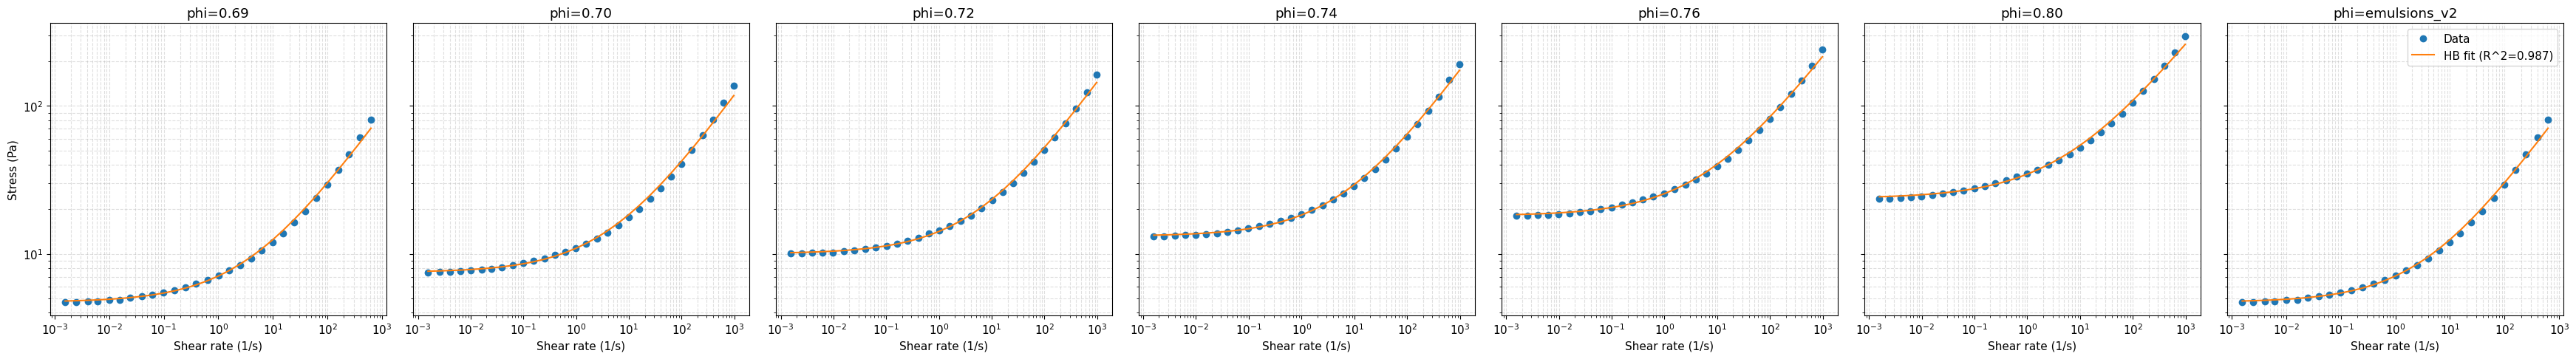

In [4]:
fig, axes = plt.subplots(1, len(files), figsize=(5*len(files),5), sharey=True)
for ax, f in zip(axes, files):
    df = pd.read_csv(f)
    df.columns = df.columns.str.strip()
    df = df.dropna()
    gamma_dot = df.iloc[:,0].to_numpy()
    tau = df.iloc[:,1].to_numpy()

    model = HerschelBulkley()
    model.fit(gamma_dot, tau, test_mode='rotation')
    tau_pred = model.predict(gamma_dot)
    r2 = model.score(gamma_dot, tau)

    ax.loglog(gamma_dot, tau, 'o', label='Data')
    ax.loglog(gamma_dot, tau_pred, '-', label=f'HB fit (R^2={r2:.3f})')
    ax.set_title(f'phi={f.stem}')
    ax.set_xlabel('Shear rate (1/s)')
    ax.grid(True, which='both', ls='--', alpha=0.4)
axes[0].set_ylabel('Stress (Pa)')
axes[-1].legend()
plt.tight_layout()
plt.tight_layout()
display(fig)
plt.close(fig)

## Bayesian workflow (NLSQ → best model → NUTS diagnostics)

Model ranking (R²): [('model', 0.987)]


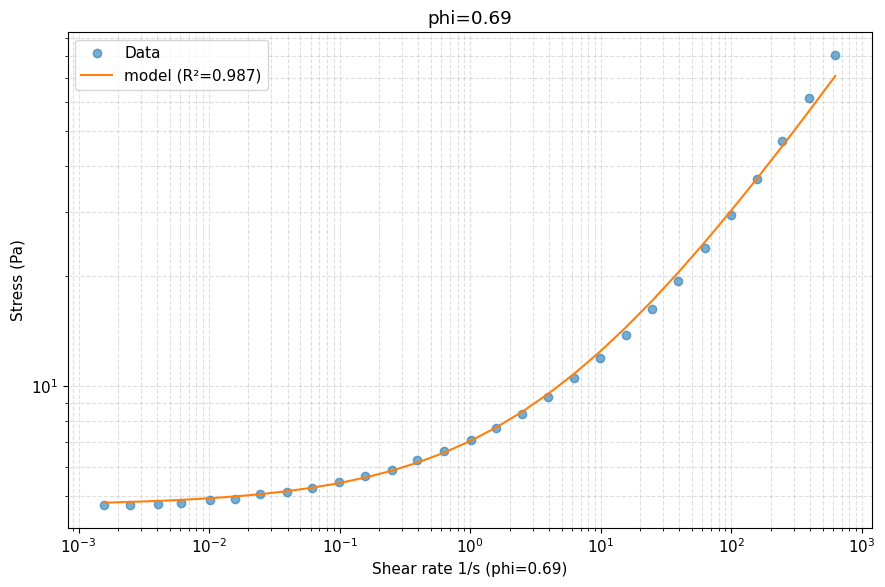

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   0%|          | 1/4000 [00:00<43:06,  1.55it/s, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   8%|▊         | 307/4000 [00:00<00:06, 554.81it/s, 63 steps of size 9.45e-02. acc. prob=0.78]

warmup:  18%|█▊        | 737/4000 [00:00<00:02, 1323.88it/s, 3 steps of size 8.40e-02. acc. prob=0.79]

sample:  29%|██▉       | 1160/4000 [00:00<00:01, 1982.59it/s, 39 steps of size 6.46e-02. acc. prob=0.94]

sample:  39%|███▉      | 1559/4000 [00:01<00:00, 2473.54it/s, 95 steps of size 6.46e-02. acc. prob=0.94]

sample:  49%|████▉     | 1961/4000 [00:01<00:00, 2872.75it/s, 63 steps of size 6.46e-02. acc. prob=0.93]

sample:  59%|█████▉    | 2355/4000 [00:01<00:00, 3157.86it/s, 63 steps of size 6.46e-02. acc. prob=0.94]

sample:  69%|██████▉   | 2751/4000 [00:01<00:00, 3379.22it/s, 31 steps of size 6.46e-02. acc. prob=0.93]

sample:  79%|███████▉  | 3151/4000 [00:01<00:00, 3554.67it/s, 63 steps of size 6.46e-02. acc. prob=0.93]

sample:  89%|████████▊ | 3548/4000 [00:01<00:00, 3674.32it/s, 31 steps of size 6.46e-02. acc. prob=0.93]

sample:  99%|█████████▊| 3946/4000 [00:01<00:00, 3763.45it/s, 31 steps of size 6.46e-02. acc. prob=0.93]

sample: 100%|██████████| 4000/4000 [00:01<00:00, 2406.55it/s, 31 steps of size 6.46e-02. acc. prob=0.93]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   8%|▊         | 310/4000 [00:00<00:01, 3096.07it/s, 15 steps of size 8.67e-02. acc. prob=0.78]

warmup:  18%|█▊        | 728/4000 [00:00<00:00, 3732.66it/s, 31 steps of size 8.34e-02. acc. prob=0.79]

sample:  29%|██▊       | 1145/4000 [00:00<00:00, 3928.39it/s, 63 steps of size 6.99e-02. acc. prob=0.94]

sample:  38%|███▊      | 1538/4000 [00:00<00:00, 3902.18it/s, 63 steps of size 6.99e-02. acc. prob=0.95]

sample:  48%|████▊     | 1929/4000 [00:00<00:00, 3900.80it/s, 31 steps of size 6.99e-02. acc. prob=0.95]

sample:  58%|█████▊    | 2320/4000 [00:00<00:00, 3882.49it/s, 63 steps of size 6.99e-02. acc. prob=0.95]

sample:  68%|██████▊   | 2709/4000 [00:00<00:00, 3871.16it/s, 19 steps of size 6.99e-02. acc. prob=0.95]

sample:  78%|███████▊  | 3106/4000 [00:00<00:00, 3902.02it/s, 31 steps of size 6.99e-02. acc. prob=0.95]

sample:  87%|████████▋ | 3497/4000 [00:00<00:00, 3902.91it/s, 15 steps of size 6.99e-02. acc. prob=0.95]

sample:  97%|█████████▋| 3888/4000 [00:01<00:00, 3900.31it/s, 27 steps of size 6.99e-02. acc. prob=0.95]

sample: 100%|██████████| 4000/4000 [00:01<00:00, 3862.22it/s, 63 steps of size 6.99e-02. acc. prob=0.95]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   8%|▊         | 313/4000 [00:00<00:01, 3119.80it/s, 127 steps of size 5.59e-02. acc. prob=0.78]

warmup:  18%|█▊        | 732/4000 [00:00<00:00, 3744.30it/s, 31 steps of size 1.08e-01. acc. prob=0.79] 

sample:  29%|██▉       | 1152/4000 [00:00<00:00, 3951.67it/s, 31 steps of size 7.97e-02. acc. prob=0.92]

sample:  39%|███▉      | 1559/4000 [00:00<00:00, 3993.82it/s, 63 steps of size 7.97e-02. acc. prob=0.93]

sample:  49%|████▉     | 1964/4000 [00:00<00:00, 4012.65it/s, 47 steps of size 7.97e-02. acc. prob=0.93]

sample:  59%|█████▉    | 2367/4000 [00:00<00:00, 4016.59it/s, 63 steps of size 7.97e-02. acc. prob=0.93]

sample:  69%|██████▉   | 2774/4000 [00:00<00:00, 4030.40it/s, 63 steps of size 7.97e-02. acc. prob=0.93]

sample:  80%|███████▉  | 3182/4000 [00:00<00:00, 4045.55it/s, 31 steps of size 7.97e-02. acc. prob=0.93]

sample:  90%|████████▉ | 3590/4000 [00:00<00:00, 4052.92it/s, 39 steps of size 7.97e-02. acc. prob=0.93]

sample: 100%|██████████| 4000/4000 [00:01<00:00, 3996.41it/s, 63 steps of size 7.97e-02. acc. prob=0.93]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   7%|▋         | 298/4000 [00:00<00:01, 2979.04it/s, 63 steps of size 8.18e-02. acc. prob=0.78]

warmup:  15%|█▍        | 596/4000 [00:00<00:01, 2942.23it/s, 7 steps of size 7.98e-02. acc. prob=0.79] 

sample:  26%|██▌       | 1034/4000 [00:00<00:00, 3591.34it/s, 63 steps of size 7.33e-02. acc. prob=0.95]

sample:  36%|███▌      | 1443/4000 [00:00<00:00, 3784.95it/s, 63 steps of size 7.33e-02. acc. prob=0.93]

sample:  46%|████▌     | 1845/4000 [00:00<00:00, 3867.75it/s, 63 steps of size 7.33e-02. acc. prob=0.93]

sample:  56%|█████▋    | 2258/4000 [00:00<00:00, 3953.27it/s, 63 steps of size 7.33e-02. acc. prob=0.93]

sample:  67%|██████▋   | 2662/4000 [00:00<00:00, 3979.59it/s, 7 steps of size 7.33e-02. acc. prob=0.93] 

sample:  77%|███████▋  | 3063/4000 [00:00<00:00, 3989.16it/s, 63 steps of size 7.33e-02. acc. prob=0.93]

sample:  87%|████████▋ | 3463/4000 [00:00<00:00, 3990.59it/s, 47 steps of size 7.33e-02. acc. prob=0.93]

sample:  97%|█████████▋| 3880/4000 [00:01<00:00, 4045.25it/s, 63 steps of size 7.33e-02. acc. prob=0.93]

sample: 100%|██████████| 4000/4000 [00:01<00:00, 3869.67it/s, 39 steps of size 7.33e-02. acc. prob=0.93]

array([[<Axes: ylabel='n'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='sigma'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='K', ylabel='sigma_y'>, <Axes: xlabel='n'>,
        <Axes: xlabel='sigma'>]], dtype=object)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

Skipping energy plot due to: 'Dataset' object has no attribute 'energy'


array([[<Axes: title={'center': 'K\n0'}>,
        <Axes: title={'center': 'K\n1'}>,
        <Axes: title={'center': 'K\n2'}>,
        <Axes: title={'center': 'K\n3'}>],
       [<Axes: title={'center': 'n\n0'}>,
        <Axes: title={'center': 'n\n1'}>,
        <Axes: title={'center': 'n\n2'}>,
        <Axes: title={'center': 'n\n3'}>],
       [<Axes: title={'center': 'sigma\n0'}>,
        <Axes: title={'center': 'sigma\n1'}>,
        <Axes: title={'center': 'sigma\n2'}>,
        <Axes: title={'center': 'sigma\n3'}>],
       [<Axes: title={'center': 'sigma_y\n0'}>,
        <Axes: title={'center': 'sigma_y\n1'}>,
        <Axes: title={'center': 'sigma_y\n2'}>,
        <Axes: title={'center': 'sigma_y\n3'}>]], dtype=object)

array([<Axes: title={'center': 'K'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <Axes: title={'center': 'n'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <Axes: title={'center': 'sigma'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <Axes: title={'center': 'sigma_y'}, xlabel='Rank (all chains)', ylabel='Chain'>],
      dtype=object)

array([<Axes: title={'center': 'K'}, xlabel='Total number of draws', ylabel='ESS'>,
       <Axes: title={'center': 'n'}, xlabel='Total number of draws', ylabel='ESS'>,
       <Axes: title={'center': 'sigma'}, xlabel='Total number of draws', ylabel='ESS'>,
       <Axes: title={'center': 'sigma_y'}, xlabel='Total number of draws', ylabel='ESS'>],
      dtype=object)

Model ranking (R²): [('model', 0.983)]


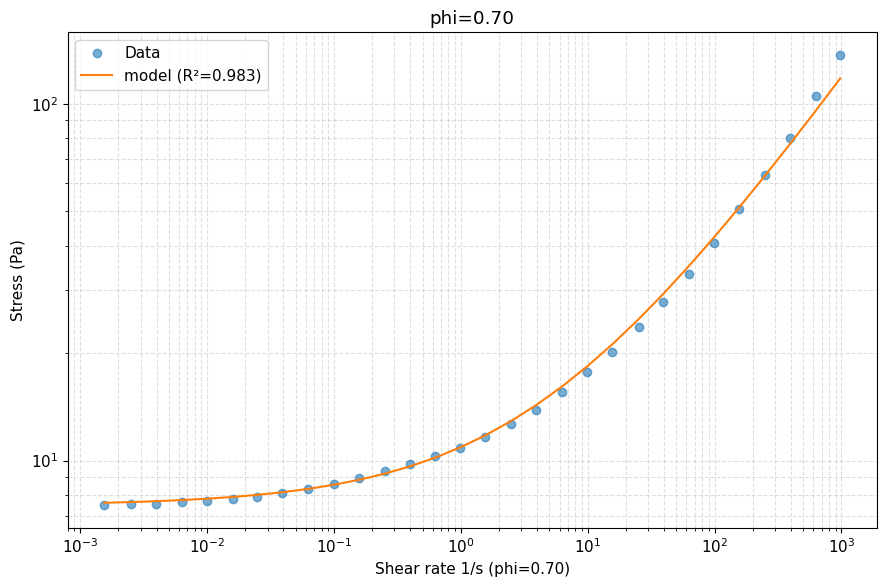

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   0%|          | 1/4000 [00:00<35:24,  1.88it/s, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   7%|▋         | 298/4000 [00:00<00:05, 630.43it/s, 127 steps of size 6.86e-02. acc. prob=0.78]

warmup:  18%|█▊        | 719/4000 [00:00<00:02, 1461.55it/s, 47 steps of size 1.05e-01. acc. prob=0.79]

sample:  29%|██▊       | 1143/4000 [00:00<00:01, 2152.22it/s, 63 steps of size 6.60e-02. acc. prob=0.93]

sample:  39%|███▊      | 1543/4000 [00:00<00:00, 2635.88it/s, 47 steps of size 6.60e-02. acc. prob=0.93]

sample:  49%|████▉     | 1951/4000 [00:01<00:00, 3029.24it/s, 47 steps of size 6.60e-02. acc. prob=0.93]

sample:  59%|█████▊    | 2345/4000 [00:01<00:00, 3283.21it/s, 63 steps of size 6.60e-02. acc. prob=0.93]

sample:  69%|██████▉   | 2752/4000 [00:01<00:00, 3505.18it/s, 63 steps of size 6.60e-02. acc. prob=0.93]

sample:  79%|███████▉  | 3159/4000 [00:01<00:00, 3667.76it/s, 15 steps of size 6.60e-02. acc. prob=0.93]

sample:  89%|████████▉ | 3562/4000 [00:01<00:00, 3770.07it/s, 63 steps of size 6.60e-02. acc. prob=0.93]

sample:  99%|█████████▉| 3966/4000 [00:01<00:00, 3847.31it/s, 31 steps of size 6.60e-02. acc. prob=0.93]

sample: 100%|██████████| 4000/4000 [00:01<00:00, 2592.40it/s, 63 steps of size 6.60e-02. acc. prob=0.93]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   9%|▊         | 343/4000 [00:00<00:01, 3424.49it/s, 15 steps of size 8.48e-02. acc. prob=0.78]

warmup:  19%|█▉        | 758/4000 [00:00<00:00, 3844.74it/s, 31 steps of size 7.48e-02. acc. prob=0.79]

sample:  29%|██▉       | 1172/4000 [00:00<00:00, 3977.69it/s, 47 steps of size 7.66e-02. acc. prob=0.92]

sample:  40%|███▉      | 1582/4000 [00:00<00:00, 4021.92it/s, 63 steps of size 7.66e-02. acc. prob=0.92]

sample:  50%|████▉     | 1998/4000 [00:00<00:00, 4067.33it/s, 63 steps of size 7.66e-02. acc. prob=0.92]

sample:  60%|██████    | 2408/4000 [00:00<00:00, 4075.65it/s, 63 steps of size 7.66e-02. acc. prob=0.92]

sample:  71%|███████   | 2823/4000 [00:00<00:00, 4099.55it/s, 23 steps of size 7.66e-02. acc. prob=0.93]

sample:  81%|████████  | 3233/4000 [00:00<00:00, 3746.64it/s, 11 steps of size 7.66e-02. acc. prob=0.92]

sample:  91%|█████████ | 3646/4000 [00:00<00:00, 3858.55it/s, 63 steps of size 7.66e-02. acc. prob=0.93]

sample: 100%|██████████| 4000/4000 [00:01<00:00, 3935.75it/s, 63 steps of size 7.66e-02. acc. prob=0.93]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   8%|▊         | 322/4000 [00:00<00:01, 3218.40it/s, 127 steps of size 5.75e-02. acc. prob=0.78]

warmup:  18%|█▊        | 723/4000 [00:00<00:00, 3683.86it/s, 47 steps of size 8.10e-02. acc. prob=0.79] 

sample:  29%|██▉       | 1154/4000 [00:00<00:00, 3967.34it/s, 47 steps of size 7.93e-02. acc. prob=0.90]

sample:  39%|███▉      | 1569/4000 [00:00<00:00, 4036.38it/s, 31 steps of size 7.93e-02. acc. prob=0.91]

sample:  50%|████▉     | 1992/4000 [00:00<00:00, 4103.90it/s, 63 steps of size 7.93e-02. acc. prob=0.91]

sample:  60%|██████    | 2404/4000 [00:00<00:00, 4109.08it/s, 63 steps of size 7.93e-02. acc. prob=0.91]

sample:  70%|███████   | 2816/4000 [00:00<00:00, 4112.48it/s, 31 steps of size 7.93e-02. acc. prob=0.91]

sample:  81%|████████  | 3228/4000 [00:00<00:00, 4095.00it/s, 31 steps of size 7.93e-02. acc. prob=0.91]

sample:  91%|█████████ | 3638/4000 [00:00<00:00, 4092.96it/s, 31 steps of size 7.93e-02. acc. prob=0.91]

sample: 100%|██████████| 4000/4000 [00:00<00:00, 4042.74it/s, 63 steps of size 7.93e-02. acc. prob=0.91]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   8%|▊         | 311/4000 [00:00<00:01, 3103.41it/s, 95 steps of size 6.05e-02. acc. prob=0.78]

warmup:  18%|█▊        | 712/4000 [00:00<00:00, 3634.18it/s, 23 steps of size 9.41e-02. acc. prob=0.79]

sample:  28%|██▊       | 1105/4000 [00:00<00:00, 3767.93it/s, 63 steps of size 7.45e-02. acc. prob=0.94]

sample:  38%|███▊      | 1509/4000 [00:00<00:00, 3874.58it/s, 63 steps of size 7.45e-02. acc. prob=0.93]

sample:  48%|████▊     | 1910/4000 [00:00<00:00, 3922.27it/s, 63 steps of size 7.45e-02. acc. prob=0.93]

sample:  58%|█████▊    | 2307/4000 [00:00<00:00, 3934.39it/s, 63 steps of size 7.45e-02. acc. prob=0.93]

sample:  68%|██████▊   | 2704/4000 [00:00<00:00, 3944.52it/s, 29 steps of size 7.45e-02. acc. prob=0.93]

sample:  78%|███████▊  | 3100/4000 [00:00<00:00, 3948.72it/s, 15 steps of size 7.45e-02. acc. prob=0.93]

sample:  87%|████████▋ | 3495/4000 [00:00<00:00, 3942.75it/s, 63 steps of size 7.45e-02. acc. prob=0.93]

sample:  97%|█████████▋| 3898/4000 [00:01<00:00, 3967.32it/s, 7 steps of size 7.45e-02. acc. prob=0.93] 

sample: 100%|██████████| 4000/4000 [00:01<00:00, 3895.70it/s, 63 steps of size 7.45e-02. acc. prob=0.93]

array([[<Axes: ylabel='n'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='sigma'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='K', ylabel='sigma_y'>, <Axes: xlabel='n'>,
        <Axes: xlabel='sigma'>]], dtype=object)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

Skipping energy plot due to: 'Dataset' object has no attribute 'energy'


array([[<Axes: title={'center': 'K\n0'}>,
        <Axes: title={'center': 'K\n1'}>,
        <Axes: title={'center': 'K\n2'}>,
        <Axes: title={'center': 'K\n3'}>],
       [<Axes: title={'center': 'n\n0'}>,
        <Axes: title={'center': 'n\n1'}>,
        <Axes: title={'center': 'n\n2'}>,
        <Axes: title={'center': 'n\n3'}>],
       [<Axes: title={'center': 'sigma\n0'}>,
        <Axes: title={'center': 'sigma\n1'}>,
        <Axes: title={'center': 'sigma\n2'}>,
        <Axes: title={'center': 'sigma\n3'}>],
       [<Axes: title={'center': 'sigma_y\n0'}>,
        <Axes: title={'center': 'sigma_y\n1'}>,
        <Axes: title={'center': 'sigma_y\n2'}>,
        <Axes: title={'center': 'sigma_y\n3'}>]], dtype=object)

array([<Axes: title={'center': 'K'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <Axes: title={'center': 'n'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <Axes: title={'center': 'sigma'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <Axes: title={'center': 'sigma_y'}, xlabel='Rank (all chains)', ylabel='Chain'>],
      dtype=object)

array([<Axes: title={'center': 'K'}, xlabel='Total number of draws', ylabel='ESS'>,
       <Axes: title={'center': 'n'}, xlabel='Total number of draws', ylabel='ESS'>,
       <Axes: title={'center': 'sigma'}, xlabel='Total number of draws', ylabel='ESS'>,
       <Axes: title={'center': 'sigma_y'}, xlabel='Total number of draws', ylabel='ESS'>],
      dtype=object)

Model ranking (R²): [('model', 0.99)]


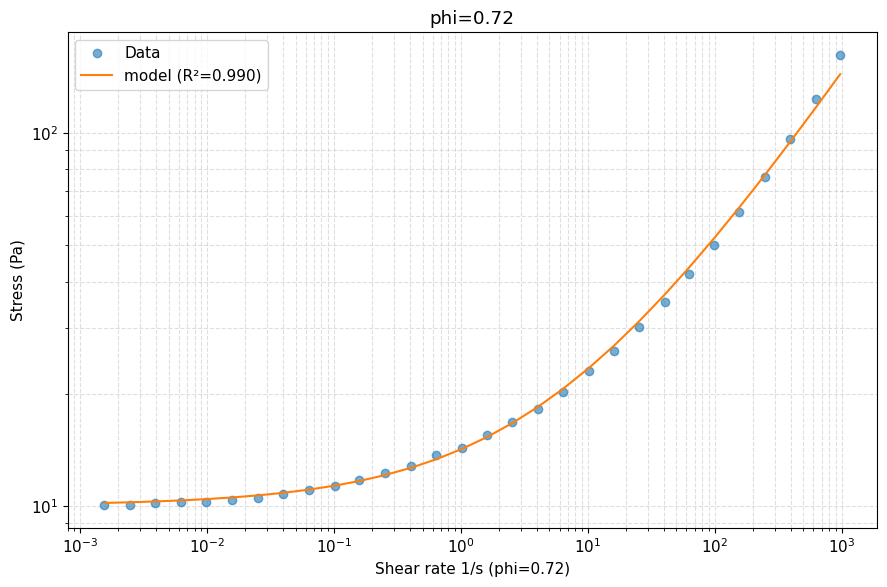

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   0%|          | 1/4000 [00:00<35:10,  1.90it/s, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   7%|▋         | 287/4000 [00:00<00:06, 610.78it/s, 55 steps of size 1.05e-01. acc. prob=0.78]

warmup:  17%|█▋        | 694/4000 [00:00<00:02, 1417.64it/s, 59 steps of size 6.81e-02. acc. prob=0.79]

sample:  28%|██▊       | 1128/4000 [00:00<00:01, 2147.08it/s, 39 steps of size 8.22e-02. acc. prob=0.90]

sample:  39%|███▉      | 1557/4000 [00:00<00:00, 2709.31it/s, 27 steps of size 8.22e-02. acc. prob=0.90]

sample:  50%|████▉     | 1987/4000 [00:01<00:00, 3142.54it/s, 31 steps of size 8.22e-02. acc. prob=0.90]

sample:  60%|██████    | 2415/4000 [00:01<00:00, 3461.02it/s, 11 steps of size 8.22e-02. acc. prob=0.90]

sample:  71%|███████   | 2844/4000 [00:01<00:00, 3697.77it/s, 31 steps of size 8.22e-02. acc. prob=0.90]

sample:  82%|████████▏ | 3277/4000 [00:01<00:00, 3879.62it/s, 31 steps of size 8.22e-02. acc. prob=0.90]

sample:  93%|█████████▎| 3706/4000 [00:01<00:00, 3996.47it/s, 55 steps of size 8.22e-02. acc. prob=0.90]

sample: 100%|██████████| 4000/4000 [00:01<00:00, 2670.11it/s, 31 steps of size 8.22e-02. acc. prob=0.90]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   9%|▉         | 351/4000 [00:00<00:01, 3505.48it/s, 127 steps of size 3.59e-02. acc. prob=0.78]

warmup:  18%|█▊        | 702/4000 [00:00<00:01, 3189.34it/s, 31 steps of size 1.47e-01. acc. prob=0.79] 

sample:  28%|██▊       | 1113/4000 [00:00<00:00, 3583.23it/s, 63 steps of size 6.32e-02. acc. prob=0.96]

sample:  37%|███▋      | 1485/4000 [00:00<00:00, 3634.95it/s, 63 steps of size 6.32e-02. acc. prob=0.96]

sample:  47%|████▋     | 1862/4000 [00:00<00:00, 3679.76it/s, 47 steps of size 6.32e-02. acc. prob=0.96]

sample:  56%|█████▌    | 2232/4000 [00:00<00:00, 3680.10it/s, 15 steps of size 6.32e-02. acc. prob=0.96]

sample:  65%|██████▌   | 2601/4000 [00:00<00:00, 3679.97it/s, 31 steps of size 6.32e-02. acc. prob=0.96]

sample:  75%|███████▍  | 2982/4000 [00:00<00:00, 3720.10it/s, 63 steps of size 6.32e-02. acc. prob=0.96]

sample:  84%|████████▍ | 3355/4000 [00:00<00:00, 3719.28it/s, 47 steps of size 6.32e-02. acc. prob=0.96]

sample:  93%|█████████▎| 3728/4000 [00:01<00:00, 3721.79it/s, 95 steps of size 6.32e-02. acc. prob=0.96]

sample: 100%|██████████| 4000/4000 [00:01<00:00, 3645.96it/s, 63 steps of size 6.32e-02. acc. prob=0.96]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   8%|▊         | 325/4000 [00:00<00:01, 3249.67it/s, 5 steps of size 5.63e-02. acc. prob=0.78]

warmup:  18%|█▊        | 720/4000 [00:00<00:00, 3660.19it/s, 31 steps of size 8.64e-02. acc. prob=0.79]

sample:  29%|██▉       | 1162/4000 [00:00<00:00, 4002.12it/s, 63 steps of size 9.58e-02. acc. prob=0.88]

sample:  40%|████      | 1606/4000 [00:00<00:00, 4172.55it/s, 47 steps of size 9.58e-02. acc. prob=0.89]

sample:  51%|█████     | 2034/4000 [00:00<00:00, 4211.13it/s, 63 steps of size 9.58e-02. acc. prob=0.89]

sample:  62%|██████▏   | 2462/4000 [00:00<00:00, 4232.95it/s, 19 steps of size 9.58e-02. acc. prob=0.89]

sample:  72%|███████▏  | 2896/4000 [00:00<00:00, 4264.38it/s, 63 steps of size 9.58e-02. acc. prob=0.89]

sample:  83%|████████▎ | 3334/4000 [00:00<00:00, 4300.43it/s, 31 steps of size 9.58e-02. acc. prob=0.89]

sample:  94%|█████████▍| 3774/4000 [00:00<00:00, 4329.02it/s, 31 steps of size 9.58e-02. acc. prob=0.89]

sample: 100%|██████████| 4000/4000 [00:00<00:00, 4197.46it/s, 63 steps of size 9.58e-02. acc. prob=0.89]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   8%|▊         | 315/4000 [00:00<00:01, 3138.79it/s, 127 steps of size 6.68e-02. acc. prob=0.78]

warmup:  18%|█▊        | 718/4000 [00:00<00:00, 3661.08it/s, 3 steps of size 7.80e-02. acc. prob=0.79]  

sample:  28%|██▊       | 1129/4000 [00:00<00:00, 3862.71it/s, 31 steps of size 7.00e-02. acc. prob=0.93]

sample:  38%|███▊      | 1528/4000 [00:00<00:00, 3910.08it/s, 63 steps of size 7.00e-02. acc. prob=0.93]

sample:  48%|████▊     | 1928/4000 [00:00<00:00, 3941.28it/s, 31 steps of size 7.00e-02. acc. prob=0.92]

sample:  58%|█████▊    | 2333/4000 [00:00<00:00, 3975.63it/s, 47 steps of size 7.00e-02. acc. prob=0.92]

sample:  68%|██████▊   | 2731/4000 [00:00<00:00, 3964.78it/s, 63 steps of size 7.00e-02. acc. prob=0.92]

sample:  78%|███████▊  | 3128/4000 [00:00<00:00, 3961.79it/s, 7 steps of size 7.00e-02. acc. prob=0.92] 

sample:  88%|████████▊ | 3525/4000 [00:00<00:00, 3956.14it/s, 19 steps of size 7.00e-02. acc. prob=0.92]

sample:  98%|█████████▊| 3921/4000 [00:01<00:00, 3946.09it/s, 63 steps of size 7.00e-02. acc. prob=0.92]

sample: 100%|██████████| 4000/4000 [00:01<00:00, 3903.29it/s, 35 steps of size 7.00e-02. acc. prob=0.92]

array([[<Axes: ylabel='n'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='sigma'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='K', ylabel='sigma_y'>, <Axes: xlabel='n'>,
        <Axes: xlabel='sigma'>]], dtype=object)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

Skipping energy plot due to: 'Dataset' object has no attribute 'energy'


array([[<Axes: title={'center': 'K\n0'}>,
        <Axes: title={'center': 'K\n1'}>,
        <Axes: title={'center': 'K\n2'}>,
        <Axes: title={'center': 'K\n3'}>],
       [<Axes: title={'center': 'n\n0'}>,
        <Axes: title={'center': 'n\n1'}>,
        <Axes: title={'center': 'n\n2'}>,
        <Axes: title={'center': 'n\n3'}>],
       [<Axes: title={'center': 'sigma\n0'}>,
        <Axes: title={'center': 'sigma\n1'}>,
        <Axes: title={'center': 'sigma\n2'}>,
        <Axes: title={'center': 'sigma\n3'}>],
       [<Axes: title={'center': 'sigma_y\n0'}>,
        <Axes: title={'center': 'sigma_y\n1'}>,
        <Axes: title={'center': 'sigma_y\n2'}>,
        <Axes: title={'center': 'sigma_y\n3'}>]], dtype=object)

array([<Axes: title={'center': 'K'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <Axes: title={'center': 'n'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <Axes: title={'center': 'sigma'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <Axes: title={'center': 'sigma_y'}, xlabel='Rank (all chains)', ylabel='Chain'>],
      dtype=object)

array([<Axes: title={'center': 'K'}, xlabel='Total number of draws', ylabel='ESS'>,
       <Axes: title={'center': 'n'}, xlabel='Total number of draws', ylabel='ESS'>,
       <Axes: title={'center': 'sigma'}, xlabel='Total number of draws', ylabel='ESS'>,
       <Axes: title={'center': 'sigma_y'}, xlabel='Total number of draws', ylabel='ESS'>],
      dtype=object)

Model ranking (R²): [('model', 0.992)]


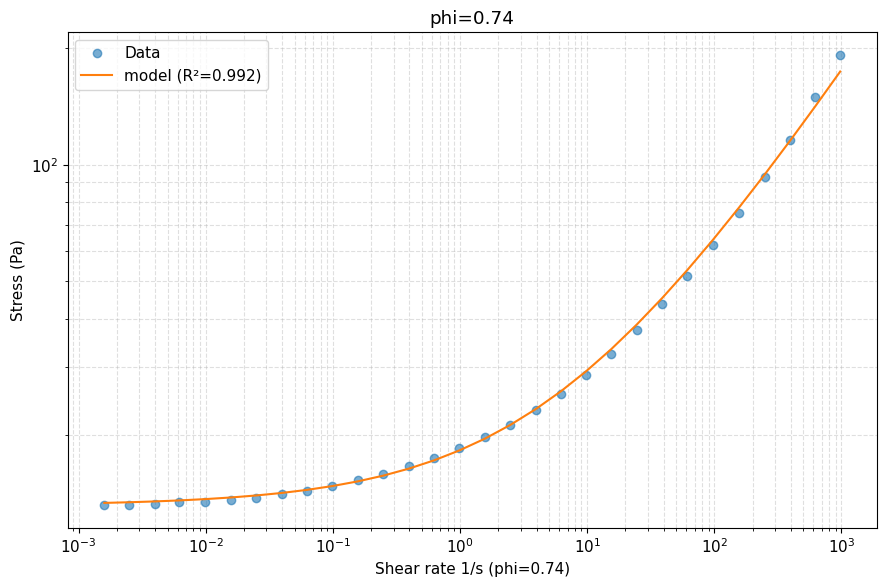

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   0%|          | 1/4000 [00:00<33:59,  1.96it/s, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   8%|▊         | 316/4000 [00:00<00:05, 690.69it/s, 63 steps of size 6.15e-02. acc. prob=0.78]

warmup:  18%|█▊        | 711/4000 [00:00<00:02, 1466.62it/s, 15 steps of size 1.39e-01. acc. prob=0.79]

sample:  28%|██▊       | 1130/4000 [00:00<00:01, 2157.03it/s, 23 steps of size 7.13e-02. acc. prob=0.93]

sample:  38%|███▊      | 1534/4000 [00:00<00:00, 2657.53it/s, 63 steps of size 7.13e-02. acc. prob=0.93]

sample:  49%|████▊     | 1944/4000 [00:01<00:00, 3053.91it/s, 31 steps of size 7.13e-02. acc. prob=0.93]

sample:  59%|█████▊    | 2344/4000 [00:01<00:00, 3320.25it/s, 59 steps of size 7.13e-02. acc. prob=0.93]

sample:  69%|██████▉   | 2750/4000 [00:01<00:00, 3531.62it/s, 31 steps of size 7.13e-02. acc. prob=0.93]

sample:  79%|███████▉  | 3150/4000 [00:01<00:00, 3667.77it/s, 63 steps of size 7.13e-02. acc. prob=0.93]

sample:  89%|████████▉ | 3560/4000 [00:01<00:00, 3790.93it/s, 63 steps of size 7.13e-02. acc. prob=0.93]

sample:  99%|█████████▉| 3967/4000 [00:01<00:00, 3869.49it/s, 63 steps of size 7.13e-02. acc. prob=0.93]

sample: 100%|██████████| 4000/4000 [00:01<00:00, 2631.75it/s, 63 steps of size 7.13e-02. acc. prob=0.93]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   5%|▌         | 218/4000 [00:00<00:01, 2178.94it/s, 19 steps of size 8.03e-02. acc. prob=0.78]

warmup:  15%|█▌        | 614/4000 [00:00<00:01, 3223.85it/s, 31 steps of size 1.23e-01. acc. prob=0.79]

sample:  26%|██▌       | 1043/4000 [00:00<00:00, 3707.49it/s, 63 steps of size 6.55e-02. acc. prob=0.93]

sample:  36%|███▌      | 1421/4000 [00:00<00:00, 3735.08it/s, 7 steps of size 6.55e-02. acc. prob=0.94] 

sample:  45%|████▌     | 1807/4000 [00:00<00:00, 3776.80it/s, 63 steps of size 6.55e-02. acc. prob=0.95]

sample:  55%|█████▍    | 2185/4000 [00:00<00:00, 3773.41it/s, 39 steps of size 6.55e-02. acc. prob=0.95]

sample:  64%|██████▍   | 2565/4000 [00:00<00:00, 3780.32it/s, 31 steps of size 6.55e-02. acc. prob=0.95]

sample:  74%|███████▎  | 2944/4000 [00:00<00:00, 3759.06it/s, 51 steps of size 6.55e-02. acc. prob=0.95]

sample:  83%|████████▎ | 3320/4000 [00:00<00:00, 3750.01it/s, 31 steps of size 6.55e-02. acc. prob=0.95]

sample:  92%|█████████▏| 3698/4000 [00:01<00:00, 3756.42it/s, 63 steps of size 6.55e-02. acc. prob=0.95]

sample: 100%|██████████| 4000/4000 [00:01<00:00, 3685.52it/s, 63 steps of size 6.55e-02. acc. prob=0.95]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   8%|▊         | 339/4000 [00:00<00:01, 3382.14it/s, 63 steps of size 3.50e-02. acc. prob=0.78]

warmup:  18%|█▊        | 740/4000 [00:00<00:00, 3749.41it/s, 63 steps of size 7.81e-02. acc. prob=0.79]

sample:  29%|██▊       | 1144/4000 [00:00<00:00, 3880.45it/s, 19 steps of size 7.46e-02. acc. prob=0.92]

sample:  39%|███▊      | 1548/4000 [00:00<00:00, 3939.20it/s, 63 steps of size 7.46e-02. acc. prob=0.93]

sample:  49%|████▉     | 1963/4000 [00:00<00:00, 4011.11it/s, 63 steps of size 7.46e-02. acc. prob=0.93]

sample:  59%|█████▉    | 2371/4000 [00:00<00:00, 4033.41it/s, 7 steps of size 7.46e-02. acc. prob=0.93] 

sample:  70%|██████▉   | 2781/4000 [00:00<00:00, 4054.69it/s, 31 steps of size 7.46e-02. acc. prob=0.93]

sample:  80%|███████▉  | 3187/4000 [00:00<00:00, 4050.72it/s, 3 steps of size 7.46e-02. acc. prob=0.93] 

sample:  90%|████████▉ | 3594/4000 [00:00<00:00, 4054.09it/s, 31 steps of size 7.46e-02. acc. prob=0.93]

sample: 100%|██████████| 4000/4000 [00:01<00:00, 3996.52it/s, 31 steps of size 7.46e-02. acc. prob=0.93]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   8%|▊         | 308/4000 [00:00<00:01, 3076.26it/s, 3 steps of size 5.01e-02. acc. prob=0.78]

warmup:  18%|█▊        | 704/4000 [00:00<00:00, 3592.96it/s, 31 steps of size 6.94e-02. acc. prob=0.79]

sample:  28%|██▊       | 1107/4000 [00:00<00:00, 3789.72it/s, 15 steps of size 6.57e-02. acc. prob=0.95]

sample:  38%|███▊      | 1500/4000 [00:00<00:00, 3840.96it/s, 63 steps of size 6.57e-02. acc. prob=0.93]

sample:  47%|████▋     | 1885/4000 [00:00<00:00, 3815.64it/s, 31 steps of size 6.57e-02. acc. prob=0.93]

sample:  57%|█████▋    | 2274/4000 [00:00<00:00, 3837.14it/s, 63 steps of size 6.57e-02. acc. prob=0.93]

sample:  66%|██████▋   | 2658/4000 [00:00<00:00, 3826.01it/s, 3 steps of size 6.57e-02. acc. prob=0.93] 

sample:  76%|███████▋  | 3052/4000 [00:00<00:00, 3859.67it/s, 63 steps of size 6.57e-02. acc. prob=0.93]

sample:  86%|████████▌ | 3438/4000 [00:00<00:00, 3855.83it/s, 63 steps of size 6.57e-02. acc. prob=0.93]

sample:  96%|█████████▌| 3824/4000 [00:01<00:00, 3846.92it/s, 63 steps of size 6.57e-02. acc. prob=0.93]

sample: 100%|██████████| 4000/4000 [00:01<00:00, 3811.26it/s, 63 steps of size 6.57e-02. acc. prob=0.93]

array([[<Axes: ylabel='n'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='sigma'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='K', ylabel='sigma_y'>, <Axes: xlabel='n'>,
        <Axes: xlabel='sigma'>]], dtype=object)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

Skipping energy plot due to: 'Dataset' object has no attribute 'energy'


array([[<Axes: title={'center': 'K\n0'}>,
        <Axes: title={'center': 'K\n1'}>,
        <Axes: title={'center': 'K\n2'}>,
        <Axes: title={'center': 'K\n3'}>],
       [<Axes: title={'center': 'n\n0'}>,
        <Axes: title={'center': 'n\n1'}>,
        <Axes: title={'center': 'n\n2'}>,
        <Axes: title={'center': 'n\n3'}>],
       [<Axes: title={'center': 'sigma\n0'}>,
        <Axes: title={'center': 'sigma\n1'}>,
        <Axes: title={'center': 'sigma\n2'}>,
        <Axes: title={'center': 'sigma\n3'}>],
       [<Axes: title={'center': 'sigma_y\n0'}>,
        <Axes: title={'center': 'sigma_y\n1'}>,
        <Axes: title={'center': 'sigma_y\n2'}>,
        <Axes: title={'center': 'sigma_y\n3'}>]], dtype=object)

array([<Axes: title={'center': 'K'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <Axes: title={'center': 'n'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <Axes: title={'center': 'sigma'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <Axes: title={'center': 'sigma_y'}, xlabel='Rank (all chains)', ylabel='Chain'>],
      dtype=object)

array([<Axes: title={'center': 'K'}, xlabel='Total number of draws', ylabel='ESS'>,
       <Axes: title={'center': 'n'}, xlabel='Total number of draws', ylabel='ESS'>,
       <Axes: title={'center': 'sigma'}, xlabel='Total number of draws', ylabel='ESS'>,
       <Axes: title={'center': 'sigma_y'}, xlabel='Total number of draws', ylabel='ESS'>],
      dtype=object)

Model ranking (R²): [('model', 0.991)]


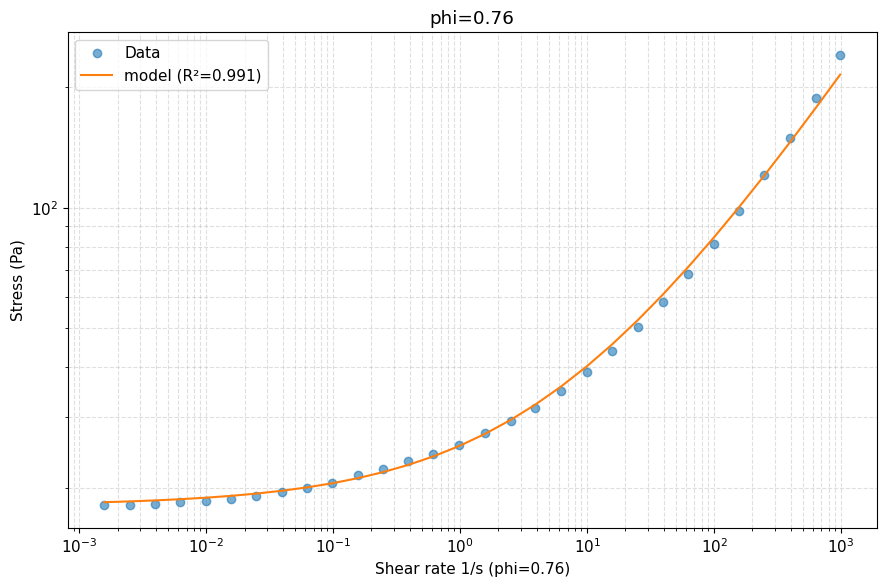

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   0%|          | 1/4000 [00:00<34:25,  1.94it/s, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   8%|▊         | 303/4000 [00:00<00:05, 655.72it/s, 31 steps of size 4.68e-02. acc. prob=0.78]

warmup:  18%|█▊        | 707/4000 [00:00<00:02, 1455.28it/s, 31 steps of size 5.38e-02. acc. prob=0.79]

sample:  27%|██▋       | 1083/4000 [00:00<00:01, 1994.68it/s, 31 steps of size 6.55e-02. acc. prob=0.93]

sample:  36%|███▌      | 1430/4000 [00:00<00:01, 2379.18it/s, 31 steps of size 6.55e-02. acc. prob=0.94]

sample:  46%|████▌     | 1837/4000 [00:01<00:00, 2837.65it/s, 15 steps of size 6.55e-02. acc. prob=0.93]

sample:  56%|█████▌    | 2232/4000 [00:01<00:00, 3147.58it/s, 7 steps of size 6.55e-02. acc. prob=0.93] 

sample:  66%|██████▌   | 2634/4000 [00:01<00:00, 3395.83it/s, 23 steps of size 6.55e-02. acc. prob=0.93]

sample:  76%|███████▌  | 3036/4000 [00:01<00:00, 3574.65it/s, 63 steps of size 6.55e-02. acc. prob=0.93]

sample:  86%|████████▌ | 3436/4000 [00:01<00:00, 3697.15it/s, 43 steps of size 6.55e-02. acc. prob=0.93]

sample:  96%|█████████▌| 3835/4000 [00:01<00:00, 3783.24it/s, 31 steps of size 6.55e-02. acc. prob=0.93]

sample: 100%|██████████| 4000/4000 [00:01<00:00, 2550.91it/s, 63 steps of size 6.55e-02. acc. prob=0.93]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   9%|▉         | 351/4000 [00:00<00:01, 3494.07it/s, 127 steps of size 5.95e-02. acc. prob=0.78]

warmup:  20%|█▉        | 789/4000 [00:00<00:00, 4013.97it/s, 15 steps of size 1.14e-01. acc. prob=0.79] 

sample:  30%|███       | 1218/4000 [00:00<00:00, 4135.07it/s, 63 steps of size 7.14e-02. acc. prob=0.94]

sample:  41%|████      | 1632/4000 [00:00<00:00, 4084.51it/s, 31 steps of size 7.14e-02. acc. prob=0.94]

sample:  51%|█████     | 2041/4000 [00:00<00:00, 4057.00it/s, 31 steps of size 7.14e-02. acc. prob=0.95]

sample:  61%|██████    | 2447/4000 [00:00<00:00, 4025.29it/s, 47 steps of size 7.14e-02. acc. prob=0.95]

sample:  71%|███████▏  | 2857/4000 [00:00<00:00, 4048.51it/s, 63 steps of size 7.14e-02. acc. prob=0.95]

sample:  82%|████████▏ | 3262/4000 [00:00<00:00, 4039.28it/s, 63 steps of size 7.14e-02. acc. prob=0.95]

sample:  92%|█████████▏| 3666/4000 [00:00<00:00, 3976.76it/s, 63 steps of size 7.14e-02. acc. prob=0.95]

sample: 100%|██████████| 4000/4000 [00:00<00:00, 4004.33it/s, 63 steps of size 7.14e-02. acc. prob=0.95]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   8%|▊         | 330/4000 [00:00<00:01, 3297.96it/s, 31 steps of size 9.38e-02. acc. prob=0.78]

warmup:  19%|█▊        | 745/4000 [00:00<00:00, 3794.28it/s, 31 steps of size 1.25e-01. acc. prob=0.79]

sample:  29%|██▉       | 1179/4000 [00:00<00:00, 4041.21it/s, 31 steps of size 8.83e-02. acc. prob=0.91]

sample:  40%|████      | 1601/4000 [00:00<00:00, 4108.98it/s, 63 steps of size 8.83e-02. acc. prob=0.91]

sample:  51%|█████     | 2022/4000 [00:00<00:00, 4141.75it/s, 63 steps of size 8.83e-02. acc. prob=0.91]

sample:  61%|██████    | 2441/4000 [00:00<00:00, 4157.45it/s, 31 steps of size 8.83e-02. acc. prob=0.92]

sample:  72%|███████▏  | 2875/4000 [00:00<00:00, 4213.67it/s, 31 steps of size 8.83e-02. acc. prob=0.91]

sample:  83%|████████▎ | 3301/4000 [00:00<00:00, 4225.68it/s, 47 steps of size 8.83e-02. acc. prob=0.92]

sample:  93%|█████████▎| 3730/4000 [00:00<00:00, 4243.72it/s, 63 steps of size 8.83e-02. acc. prob=0.91]

sample: 100%|██████████| 4000/4000 [00:00<00:00, 4143.11it/s, 63 steps of size 8.83e-02. acc. prob=0.91]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   8%|▊         | 325/4000 [00:00<00:01, 3235.12it/s, 127 steps of size 5.19e-02. acc. prob=0.78]

warmup:  19%|█▊        | 742/4000 [00:00<00:00, 3780.20it/s, 31 steps of size 6.72e-02. acc. prob=0.79] 

sample:  29%|██▉       | 1156/4000 [00:00<00:00, 3942.40it/s, 31 steps of size 7.86e-02. acc. prob=0.94]

sample:  39%|███▉      | 1575/4000 [00:00<00:00, 4036.48it/s, 47 steps of size 7.86e-02. acc. prob=0.93]

sample:  49%|████▉     | 1979/4000 [00:00<00:00, 4015.59it/s, 15 steps of size 7.86e-02. acc. prob=0.93]

sample:  60%|█████▉    | 2389/4000 [00:00<00:00, 4042.77it/s, 31 steps of size 7.86e-02. acc. prob=0.93]

sample:  70%|███████   | 2803/4000 [00:00<00:00, 4071.23it/s, 63 steps of size 7.86e-02. acc. prob=0.93]

sample:  80%|████████  | 3211/4000 [00:00<00:00, 4071.34it/s, 3 steps of size 7.86e-02. acc. prob=0.93] 

sample:  90%|█████████ | 3619/4000 [00:00<00:00, 4056.67it/s, 31 steps of size 7.86e-02. acc. prob=0.93]

sample: 100%|██████████| 4000/4000 [00:00<00:00, 4004.88it/s, 63 steps of size 7.86e-02. acc. prob=0.93]

array([[<Axes: ylabel='n'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='sigma'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='K', ylabel='sigma_y'>, <Axes: xlabel='n'>,
        <Axes: xlabel='sigma'>]], dtype=object)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

Skipping energy plot due to: 'Dataset' object has no attribute 'energy'


array([[<Axes: title={'center': 'K\n0'}>,
        <Axes: title={'center': 'K\n1'}>,
        <Axes: title={'center': 'K\n2'}>,
        <Axes: title={'center': 'K\n3'}>],
       [<Axes: title={'center': 'n\n0'}>,
        <Axes: title={'center': 'n\n1'}>,
        <Axes: title={'center': 'n\n2'}>,
        <Axes: title={'center': 'n\n3'}>],
       [<Axes: title={'center': 'sigma\n0'}>,
        <Axes: title={'center': 'sigma\n1'}>,
        <Axes: title={'center': 'sigma\n2'}>,
        <Axes: title={'center': 'sigma\n3'}>],
       [<Axes: title={'center': 'sigma_y\n0'}>,
        <Axes: title={'center': 'sigma_y\n1'}>,
        <Axes: title={'center': 'sigma_y\n2'}>,
        <Axes: title={'center': 'sigma_y\n3'}>]], dtype=object)

array([<Axes: title={'center': 'K'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <Axes: title={'center': 'n'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <Axes: title={'center': 'sigma'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <Axes: title={'center': 'sigma_y'}, xlabel='Rank (all chains)', ylabel='Chain'>],
      dtype=object)

array([<Axes: title={'center': 'K'}, xlabel='Total number of draws', ylabel='ESS'>,
       <Axes: title={'center': 'n'}, xlabel='Total number of draws', ylabel='ESS'>,
       <Axes: title={'center': 'sigma'}, xlabel='Total number of draws', ylabel='ESS'>,
       <Axes: title={'center': 'sigma_y'}, xlabel='Total number of draws', ylabel='ESS'>],
      dtype=object)

Model ranking (R²): [('model', 0.989)]


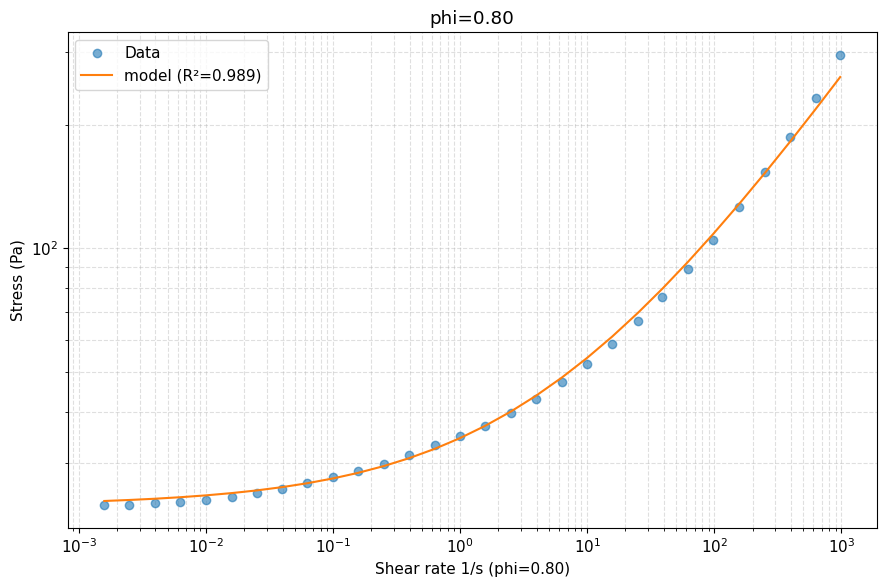

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   0%|          | 1/4000 [00:00<34:47,  1.92it/s, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   8%|▊         | 331/4000 [00:00<00:05, 710.19it/s, 15 steps of size 1.23e-01. acc. prob=0.78]

warmup:  19%|█▉        | 758/4000 [00:00<00:02, 1545.31it/s, 23 steps of size 6.89e-02. acc. prob=0.79]

sample:  30%|██▉       | 1191/4000 [00:00<00:01, 2244.17it/s, 63 steps of size 7.95e-02. acc. prob=0.93]

sample:  40%|████      | 1619/4000 [00:00<00:00, 2780.84it/s, 31 steps of size 7.95e-02. acc. prob=0.92]

sample:  51%|█████     | 2048/4000 [00:01<00:00, 3193.08it/s, 19 steps of size 7.95e-02. acc. prob=0.92]

sample:  62%|██████▏   | 2473/4000 [00:01<00:00, 3488.36it/s, 31 steps of size 7.95e-02. acc. prob=0.92]

sample:  73%|███████▎  | 2916/4000 [00:01<00:00, 3756.60it/s, 15 steps of size 7.95e-02. acc. prob=0.92]

sample:  84%|████████▎ | 3349/4000 [00:01<00:00, 3920.46it/s, 63 steps of size 7.95e-02. acc. prob=0.92]

sample:  94%|█████████▍| 3778/4000 [00:01<00:00, 4027.92it/s, 31 steps of size 7.95e-02. acc. prob=0.92]

sample: 100%|██████████| 4000/4000 [00:01<00:00, 2713.18it/s, 63 steps of size 7.95e-02. acc. prob=0.92]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   9%|▉         | 355/4000 [00:00<00:01, 3548.76it/s, 63 steps of size 7.19e-02. acc. prob=0.78]

warmup:  20%|█▉        | 785/4000 [00:00<00:00, 3983.60it/s, 63 steps of size 1.07e-01. acc. prob=0.79]

sample:  30%|███       | 1207/4000 [00:00<00:00, 4091.13it/s, 7 steps of size 7.88e-02. acc. prob=0.94]

sample:  40%|████      | 1619/4000 [00:00<00:00, 4099.35it/s, 63 steps of size 7.88e-02. acc. prob=0.94]

sample:  51%|█████     | 2029/4000 [00:00<00:00, 4098.30it/s, 63 steps of size 7.88e-02. acc. prob=0.94]

sample:  61%|██████    | 2439/4000 [00:00<00:00, 4059.42it/s, 47 steps of size 7.88e-02. acc. prob=0.94]

sample:  71%|███████   | 2847/4000 [00:00<00:00, 4062.97it/s, 63 steps of size 7.88e-02. acc. prob=0.94]

sample:  81%|████████▏ | 3254/4000 [00:00<00:00, 4027.51it/s, 31 steps of size 7.88e-02. acc. prob=0.94]

sample:  92%|█████████▏| 3667/4000 [00:00<00:00, 4056.86it/s, 31 steps of size 7.88e-02. acc. prob=0.94]

sample: 100%|██████████| 4000/4000 [00:00<00:00, 4054.08it/s, 63 steps of size 7.88e-02. acc. prob=0.94]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   9%|▊         | 343/4000 [00:00<00:01, 3425.78it/s, 11 steps of size 1.54e-01. acc. prob=0.78]

warmup:  19%|█▉        | 772/4000 [00:00<00:00, 3928.69it/s, 31 steps of size 7.86e-02. acc. prob=0.79]

sample:  30%|███       | 1204/4000 [00:00<00:00, 4105.40it/s, 31 steps of size 8.65e-02. acc. prob=0.92]

sample:  41%|████      | 1634/4000 [00:00<00:00, 4180.59it/s, 23 steps of size 8.65e-02. acc. prob=0.92]

sample:  51%|█████▏    | 2059/4000 [00:00<00:00, 4203.95it/s, 15 steps of size 8.65e-02. acc. prob=0.92]

sample:  62%|██████▏   | 2486/4000 [00:00<00:00, 4225.17it/s, 15 steps of size 8.65e-02. acc. prob=0.92]

sample:  73%|███████▎  | 2912/4000 [00:00<00:00, 4236.25it/s, 63 steps of size 8.65e-02. acc. prob=0.92]

sample:  83%|████████▎ | 3336/4000 [00:00<00:00, 4209.22it/s, 23 steps of size 8.65e-02. acc. prob=0.92]

sample:  94%|█████████▍| 3761/4000 [00:00<00:00, 4219.61it/s, 23 steps of size 8.65e-02. acc. prob=0.92]

sample: 100%|██████████| 4000/4000 [00:00<00:00, 4172.90it/s, 47 steps of size 8.65e-02. acc. prob=0.92]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   9%|▉         | 353/4000 [00:00<00:01, 3525.17it/s, 63 steps of size 8.99e-02. acc. prob=0.78]

warmup:  20%|█▉        | 785/4000 [00:00<00:00, 3987.35it/s, 63 steps of size 1.08e-01. acc. prob=0.79]

sample:  30%|██▉       | 1195/4000 [00:00<00:00, 4036.47it/s, 63 steps of size 6.79e-02. acc. prob=0.95]

sample:  40%|███▉      | 1599/4000 [00:00<00:00, 3983.04it/s, 47 steps of size 6.79e-02. acc. prob=0.95]

sample:  50%|████▉     | 1998/4000 [00:00<00:00, 3957.80it/s, 31 steps of size 6.79e-02. acc. prob=0.95]

sample:  60%|█████▉    | 2394/4000 [00:00<00:00, 3938.49it/s, 63 steps of size 6.79e-02. acc. prob=0.95]

sample:  70%|██████▉   | 2789/4000 [00:00<00:00, 3942.16it/s, 13 steps of size 6.79e-02. acc. prob=0.95]

sample:  80%|███████▉  | 3184/4000 [00:00<00:00, 3933.27it/s, 63 steps of size 6.79e-02. acc. prob=0.95]

sample:  89%|████████▉ | 3578/4000 [00:00<00:00, 3931.38it/s, 3 steps of size 6.79e-02. acc. prob=0.95] 

sample:  99%|█████████▉| 3972/4000 [00:01<00:00, 3907.29it/s, 31 steps of size 6.79e-02. acc. prob=0.95]

sample: 100%|██████████| 4000/4000 [00:01<00:00, 3927.56it/s, 35 steps of size 6.79e-02. acc. prob=0.95]

array([[<Axes: ylabel='n'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='sigma'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='K', ylabel='sigma_y'>, <Axes: xlabel='n'>,
        <Axes: xlabel='sigma'>]], dtype=object)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

Skipping energy plot due to: 'Dataset' object has no attribute 'energy'


array([[<Axes: title={'center': 'K\n0'}>,
        <Axes: title={'center': 'K\n1'}>,
        <Axes: title={'center': 'K\n2'}>,
        <Axes: title={'center': 'K\n3'}>],
       [<Axes: title={'center': 'n\n0'}>,
        <Axes: title={'center': 'n\n1'}>,
        <Axes: title={'center': 'n\n2'}>,
        <Axes: title={'center': 'n\n3'}>],
       [<Axes: title={'center': 'sigma\n0'}>,
        <Axes: title={'center': 'sigma\n1'}>,
        <Axes: title={'center': 'sigma\n2'}>,
        <Axes: title={'center': 'sigma\n3'}>],
       [<Axes: title={'center': 'sigma_y\n0'}>,
        <Axes: title={'center': 'sigma_y\n1'}>,
        <Axes: title={'center': 'sigma_y\n2'}>,
        <Axes: title={'center': 'sigma_y\n3'}>]], dtype=object)

array([<Axes: title={'center': 'K'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <Axes: title={'center': 'n'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <Axes: title={'center': 'sigma'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <Axes: title={'center': 'sigma_y'}, xlabel='Rank (all chains)', ylabel='Chain'>],
      dtype=object)

array([<Axes: title={'center': 'K'}, xlabel='Total number of draws', ylabel='ESS'>,
       <Axes: title={'center': 'n'}, xlabel='Total number of draws', ylabel='ESS'>,
       <Axes: title={'center': 'sigma'}, xlabel='Total number of draws', ylabel='ESS'>,
       <Axes: title={'center': 'sigma_y'}, xlabel='Total number of draws', ylabel='ESS'>],
      dtype=object)

Skipping model due to fit error: SVD did not converge in Linear Least Squares
No successful fits for dataset; skipping Bayesian step.


In [5]:
# Unified workflow: load → NLSQ fits → best by R² → Bayesian → diagnostics

# Fallback R² for complex data
if 'r2_complex' not in globals():
    def r2_complex(y_true, y_pred):
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
        ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
        return 1 - ss_res / ss_tot



# Handle models that return real/imag columns instead of complex numbers
if '_coerce_pred' not in globals():
    def _coerce_pred(pred):
        arr = np.asarray(pred)
        if arr.ndim == 2 and arr.shape[1] == 2 and not np.iscomplexobj(arr):
            arr = arr[:, 0] + 1j * arr[:, 1]
        return arr


NUTS_CONFIG = dict(num_chains=4, num_warmup=1000, num_samples=3000)

def _detect_datasets():
    datasets = []
    if 'G_star' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega,
            'y': G_star,
            'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)',
            'y_label': 'Complex modulus',
        })
    elif 'Gp' in globals() and 'Gpp' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega,
            'y': Gp + 1j * Gpp,
            'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)',
            'y_label': 'Complex modulus',
        })
    if 'master' in globals() and hasattr(master, 'x') and hasattr(master, 'y'):
        datasets.append({
            'X': master.x,
            'y': master.y,
            'test_mode': master.metadata.get('test_mode', 'oscillation') if hasattr(master, 'metadata') else 'oscillation',
            'x_label': 'Shifted frequency',
            'y_label': 'Mastercurve modulus',
        })
    if 't' in globals() and 'G' in globals():
        datasets.append({
            'X': t,
            'y': G,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Relaxation modulus',
        })

    if 't' in globals() and 'E_t' in globals():
        datasets.append({
            'X': t,
            'y': E_t,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Relaxation modulus',
        })
    if 't' in globals() and 'sigma' in globals():
        datasets.append({
            'X': t,
            'y': sigma,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Stress (Pa)',
        })
    if 't' in globals() and 'J' in globals():
        datasets.append({
            'X': t,
            'y': J,
            'test_mode': 'creep',
            'x_label': 'Time (s)',
            'y_label': 'Creep compliance',
        })
    if 'all_df' in globals() and hasattr(all_df, 'columns') and 'phi' in all_df.columns:
        for phi, frame in all_df.groupby('phi'):
            x_vals = frame.iloc[:, 0].to_numpy()
            y_vals = frame.iloc[:, 1].to_numpy()
            datasets.append({
                'X': x_vals,
                'y': y_vals,
                'test_mode': 'rotation',
                'x_label': f'Shear rate 1/s (phi={phi})',
                'y_label': 'Stress (Pa)',
                'label': f'phi={phi}',
            })
    if not datasets:
        raise ValueError('No datasets detected; ensure data variables are defined before running this cell.')
    return datasets


def _collect_candidate_models():
    if 'candidates' in globals() and isinstance(candidates, (list, tuple)) and candidates:
        return candidates
    models = []
    for name, obj in globals().items():
        if isinstance(obj, type):
            continue  # skip classes; require initialized models
        if hasattr(obj, 'fit_bayesian') and hasattr(obj, 'predict'):
            models.append((name, obj))
    if not models:
        raise ValueError('No candidate models found; define models before running this cell.')
    return models


def _plot_data_and_fits(ds, fits):
    fig, ax = plt.subplots(figsize=(9, 6))
    X_plot = ds['X']
    y_true = ds['y']
    if np.iscomplexobj(y_true):
        x_axis = X_plot / (2 * np.pi) if ds['test_mode'] == 'oscillation' else X_plot
        ax.loglog(x_axis, np.real(y_true), 'o', label="Data real", alpha=0.6)
        ax.loglog(x_axis, np.imag(y_true), 's', label="Data imag", alpha=0.6)
        for rec in fits:
            pred = _coerce_pred(rec['pred'])
            ax.loglog(x_axis, np.real(pred), '-', label=f"{rec['name']} Re (R²={rec['r2']:.3f})")
            ax.loglog(x_axis, np.imag(pred), '--', label=f"{rec['name']} Im")
    else:
        x_axis = X_plot
        ax.loglog(x_axis, y_true, 'o', label='Data', alpha=0.6)
        for rec in fits:
            ax.loglog(x_axis, rec['pred'], '-', label=f"{rec['name']} (R²={rec['r2']:.3f})")
    ax.set_xlabel(ds.get('x_label', 'X'))
    ax.set_ylabel(ds.get('y_label', 'Response'))
    ax.set_title(ds.get('label', f"test_mode={ds['test_mode']}"))
    ax.grid(True, which='both', ls='--', alpha=0.4)
    ax.legend()
    plt.tight_layout()
    display(fig)
    plt.close(fig)


def _plot_diagnostics(idata):
    diag_plotters = [
        ('pair', lambda: az.plot_pair(idata, divergences=True, kind='kde')),
        ('forest', lambda: az.plot_forest(idata, combined=True)),
        ('energy', lambda: az.plot_energy(idata)),
        ('autocorr', lambda: az.plot_autocorr(idata)),
        ('rank', lambda: az.plot_rank(idata)),
        ('ess', lambda: az.plot_ess(idata, kind='evolution')),
    ]
    for name, plot_fn in diag_plotters:
        try:
            obj = plot_fn()
        except Exception as exc:
            print(f"Skipping {name} plot due to: {exc}")
            continue
        plt.tight_layout()
        display(obj)
        plt.close('all')


datasets = _detect_datasets()
model_entries = _collect_candidate_models()

for ds in datasets:
    fits = []
    for name, model in model_entries:
        fitted_model = model
        fit_kwargs = {'test_mode': ds['test_mode'], 'use_log_residuals': True}
        try:
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except TypeError:
            fit_kwargs.pop('use_log_residuals', None)
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except Exception as exc:
            print(f"Skipping {name} due to fit error: {exc}")
            continue
        predict_kwargs = {'test_mode': ds['test_mode']} if 'test_mode' in fit_kwargs else {}
        try:
            pred = _coerce_pred(fitted_model.predict(ds['X'], **predict_kwargs))
        except Exception as exc:
            print(f"Skipping {name} due to predict error: {exc}")
            continue
        try:
            r2_val = r2_complex(ds['y'], pred) if np.iscomplexobj(ds['y']) else fitted_model.score(ds['X'], ds['y'])
        except Exception as exc:
            print(f"Skipping {name} due to scoring error: {exc}")
            continue
        fits.append({'name': name, 'model': fitted_model, 'pred': pred, 'r2': float(r2_val)})

    if not fits:
        print('No successful fits for dataset; skipping Bayesian step.')
        continue

    fits.sort(key=lambda rec: rec['r2'], reverse=True)
    best = fits[0]
    print(f"Model ranking (R²): {[ (rec['name'], round(rec['r2'], 3)) for rec in fits ]}")
    _plot_data_and_fits(ds, fits)

    try:
        bayes_result = best['model'].fit_bayesian(
            ds['X'],
            ds['y'],
            **NUTS_CONFIG,
            test_mode=ds['test_mode'],
        )
        idata = bayes_result.to_inference_data()
        _plot_diagnostics(idata)
    except Exception as exc:
        print(f"Skipping Bayesian step for {best['name']} due to: {exc}")
